In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display
%matplotlib inline

In [4]:
from softlearning.models.state_estimation import get_seed_data, get_training_data
seed_path = '/home/justinvyu/ray_results/gym/DClaw/TurnFreeValve3ResetFreeSwapGoal-v0/2019-08-07T14-57-41-state_gtr_2_goals_with_resets_regular_box_saving_pixels_fixed_env/id=612875d0-seed=9463_2019-08-07_14-57-42op75_8n7'
checkpoint_path = '/home/justinvyu/ray_results/gym/DClaw/TurnFreeValve3ResetFreeSwapGoal-v0/2019-08-07T14-57-41-state_gtr_2_goals_with_resets_regular_box_saving_pixels_fixed_env/'

# images, _ = get_seed_data(seed_path)
images, _ = get_training_data(checkpoint_path, limit=1)

/home/justinvyu/ray_results/gym/DClaw/TurnFreeValve3ResetFreeSwapGoal-v0/2019-08-07T14-57-41-state_gtr_2_goals_with_resets_regular_box_saving_pixels_fixed_env/id=612875d0-seed=9463_2019-08-07_14-57-42op75_8n7
/home/justinvyu/ray_results/gym/DClaw/TurnFreeValve3ResetFreeSwapGoal-v0/2019-08-07T14-57-41-state_gtr_2_goals_with_resets_regular_box_saving_pixels_fixed_env/id=612875d0-seed=9463_2019-08-07_14-57-42op75_8n7/checkpoint_100/replay_pool.pkl
/home/justinvyu/ray_results/gym/DClaw/TurnFreeValve3ResetFreeSwapGoal-v0/2019-08-07T14-57-41-state_gtr_2_goals_with_resets_regular_box_saving_pixels_fixed_env/id=612875d1-seed=6973_2019-08-07_14-57-427p781q5n
/home/justinvyu/ray_results/gym/DClaw/TurnFreeValve3ResetFreeSwapGoal-v0/2019-08-07T14-57-41-state_gtr_2_goals_with_resets_regular_box_saving_pixels_fixed_env/id=612875d1-seed=6973_2019-08-07_14-57-427p781q5n/checkpoint_100/replay_pool.pkl
/home/justinvyu/ray_results/gym/DClaw/TurnFreeValve3ResetFreeSwapGoal-v0/2019-08-07T14-57-41-state_gtr

In [5]:
images.shape

(50000, 64, 64, 3)

In [4]:
image_shape = (64, 64, 3)
num_images = images.shape[0]

# Shuffle images
np.random.shuffle(images)

In [27]:
validation_split = 0.1
split_index = int(num_images * validation_split)
num_training_examples = 300000

_train_images = images[split_index:split_index + num_training_examples]
_test_images = images[:split_index]
train_images = (_train_images / 255.).astype(np.float32)
test_images = (_test_images / 255.).astype(np.float32)

In [48]:
train_images = train_images[:200000]
train_images.shape, test_images.shape

((200000, 64, 64, 3), (150100, 64, 64, 3))

In [59]:
BATCH_SIZE = 100

def train_generator():
    for image in train_images:
        yield image

def test_generator():
    for image in test_images:
        yield image
        
train_dataset = tf.data.Dataset.from_generator(train_generator, tf.float32).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_generator(test_generator, tf.float32).batch(BATCH_SIZE)

In [52]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation=tf.keras.layers.LeakyReLU()),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation=tf.keras.layers.LeakyReLU()),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation=tf.keras.layers.LeakyReLU()),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation=tf.keras.layers.LeakyReLU()),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation=tf.keras.layers.LeakyReLU()),
        tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation=tf.keras.layers.LeakyReLU()),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=3, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

  def __call__(self, x):
    mean, logvar = self.encode(x)
    z = self.reparameterize(mean, logvar)
    x_reconstruct = self.decode(z, apply_sigmoid=True)
    return x_reconstruct

In [61]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [8]:
epochs = 500
latent_dim = 64
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [63]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
#   print(predictions, predictions.shape)
  fig = plt.figure(figsize=(4,4))
#   print(predictions[0, :, :, :])
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
generate_and_save_images(model, 0, random_vector_for_generation)

with tf.device('/GPU:0'):
    for epoch in range(1, epochs + 1):
      start_time = time.time()
      for train_x in train_dataset:
        compute_apply_gradients(model, train_x, optimizer)
      end_time = time.time()

      if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
          loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, '
              'time elapse for current epoch {}'.format(epoch,
                                                        elbo,
                                                        end_time - start_time))
        generate_and_save_images(
            model, epoch, random_vector_for_generation)

Epoch: 299, Test set ELBO: -7271.9599609375, time elapse for current epoch 23.25958752632141


In [33]:
encoder = tf.keras.Sequential(
  [
      tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),
      tf.keras.layers.Conv2D(
          filters=64, kernel_size=3, strides=(2, 2), activation=tf.keras.layers.LeakyReLU()),
      tf.keras.layers.Conv2D(
          filters=64, kernel_size=3, strides=(2, 2), activation=tf.keras.layers.LeakyReLU()),
      tf.keras.layers.Conv2D(
          filters=32, kernel_size=3, strides=(2, 2), activation=tf.keras.layers.LeakyReLU()),
      tf.keras.layers.Flatten(),
      # No activation
      tf.keras.layers.Dense(latent_dim + latent_dim),
  ]
)

decoder = tf.keras.Sequential(
    [
      tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
      tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
      tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
      tf.keras.layers.Conv2DTranspose(
          filters=64,
          kernel_size=3,
          strides=(2, 2),
          padding="SAME",
          activation=tf.keras.layers.LeakyReLU()),
      tf.keras.layers.Conv2DTranspose(
          filters=64,
          kernel_size=3,
          strides=(2, 2),
          padding="SAME",
          activation=tf.keras.layers.LeakyReLU()),
    tf.keras.layers.Conv2DTranspose(
          filters=32,
          kernel_size=3,
          strides=(2, 2),
          padding="SAME",
          activation=tf.keras.layers.LeakyReLU()),
      # No activation
      tf.keras.layers.Conv2DTranspose(
          filters=3, kernel_size=3, strides=(1, 1), padding="SAME"),
    ]
)

In [34]:
encoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 31, 64)        1792      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 32)          18464     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               200832    
Total params: 258,016
Trainable params: 258,016
Non-trainable params: 0
_________________________________________________________________


In [35]:
decoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2048)              133120    
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 64, 64, 3)         867       
Total params: 207,875
Trainable params: 207,875
Non-trainable params: 0
________________________________________________

In [ ]:
model.inference_net.save_weights('inference_weights.h5')
model.generative_net.save_weights('generative_weights.h5')

In [54]:
model = CVAE(latent_dim)
model.inference_net.load_weights('inference_weights.h5')
model.generative_net.load_weights('generative_weights.h5')

In [55]:
test_image = images[1]
test_image = (test_image / 255.).astype(np.float32)

In [56]:
mean, logvar = model.encode(test_image[None, ...])
z = model.reparameterize(mean, logvar)
x_logit = model.decode(z, apply_sigmoid=True)

In [57]:
mean, logvar

(<tf.Tensor: id=1598, shape=(1, 64), dtype=float32, numpy=
 array([[-0.51913667, -0.08083932,  0.73021525, -0.92429954, -0.06115993,
          1.9643685 , -0.13858719, -0.09147629,  2.290879  , -0.2000005 ,
         -0.06875439,  1.029193  , -0.04387467,  0.50050557, -0.21974261,
         -0.1948951 , -1.2848841 , -1.8147924 ,  0.90163743, -0.21661267,
          0.12695615,  1.182224  , -1.310476  ,  1.0174454 ,  1.3471305 ,
          2.67005   , -0.32581   , -0.39633262, -0.19917135,  0.1462048 ,
          1.5760796 ,  0.3107947 ,  0.9680461 ,  0.828787  , -0.31504482,
         -0.15717196,  0.24219647,  0.18976736,  0.1023746 , -1.2293798 ,
         -0.04903303, -0.04680696,  0.03749004, -0.08748339,  0.1127687 ,
         -0.03373482, -0.3155758 , -0.08496008,  0.24433057, -0.29107064,
          1.7132783 , -0.25419128, -0.17464094, -1.130789  , -0.21079774,
         -0.18283802,  0.16537602, -0.24851291,  0.5771202 ,  0.44713297,
         -0.7771101 ,  0.00613413,  0.17664194, -1.38

In [58]:
z

<tf.Tensor: id=1610, shape=(1, 64), dtype=float32, numpy=
array([[-4.6803403e-01, -1.6238893e+00,  7.9539907e-01, -7.5643384e-01,
         9.1632843e-01,  1.6145806e+00,  7.1813864e-01, -8.7030821e-02,
         2.3897536e+00, -2.2236453e-01, -2.9349911e-01,  9.4393682e-01,
        -7.6915324e-02,  6.2356460e-01,  1.8960576e-01, -1.4005356e+00,
        -1.9483696e+00, -1.7799091e+00,  9.7199917e-01,  8.6677074e-02,
         1.3936527e-02,  1.6223736e+00, -1.3425428e+00,  1.0716448e+00,
         1.3504395e+00,  2.6209688e+00,  2.5264564e-01, -1.2308198e-01,
        -1.0589564e+00,  1.0374725e-02,  1.4385002e+00,  5.0701517e-01,
         4.8499134e-01,  8.6278123e-01, -1.0693438e+00, -1.4724602e-01,
         3.3852696e-01, -1.2867756e+00,  6.5155697e-01, -1.4717600e+00,
        -1.9219768e-01,  1.3221292e+00, -4.6398959e-01,  8.8151991e-01,
         3.1398582e+00,  6.7959243e-01, -5.2032459e-01, -1.1225575e-01,
        -2.6857123e-02, -6.3407671e-01,  1.6987305e+00, -5.2052099e-01,
      

In [59]:
x_logit

<tf.Tensor: id=1737, shape=(1, 64, 64, 3), dtype=float32, numpy=
array([[[[0.6183833 , 0.6169276 , 0.61169875],
         [0.6169667 , 0.61803526, 0.61699533],
         [0.61916816, 0.6164016 , 0.61584896],
         ...,
         [0.62841934, 0.63468564, 0.6140066 ],
         [0.61373115, 0.61573195, 0.6127956 ],
         [0.6206496 , 0.62589926, 0.6084108 ]],

        [[0.6270256 , 0.63400435, 0.63098454],
         [0.620309  , 0.62419677, 0.62640786],
         [0.6280805 , 0.6262302 , 0.62372744],
         ...,
         [0.6443592 , 0.63642955, 0.62117994],
         [0.64673716, 0.6273353 , 0.6346398 ],
         [0.63714683, 0.6359458 , 0.6279057 ]],

        [[0.6444567 , 0.64978755, 0.6499881 ],
         [0.6480714 , 0.6443451 , 0.6487138 ],
         [0.6397228 , 0.6402104 , 0.6465827 ],
         ...,
         [0.62924707, 0.6368185 , 0.6210072 ],
         [0.6558043 , 0.6345082 , 0.64427286],
         [0.6405484 , 0.6363962 , 0.63799864]],

        ...,

        [[0.5646288 , 0.556

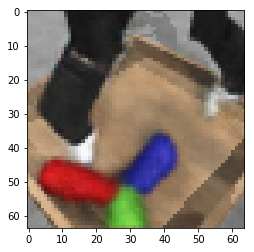

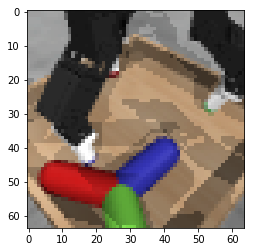

In [60]:
decoded = x_logit.numpy()
plt.imshow(decoded[0])
plt.show()
plt.imshow(test_image)
plt.show()

In [34]:
l2_loss = np.linalg.norm(decoded - test_image)
l2_loss

6.5227165

In [2]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('vae_images/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)

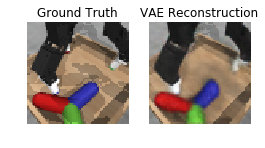

In [66]:
def plot_side_by_side(img1, img2, title1='', title2='', figsize=(4, 2)):
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.title(title1)
    plt.imshow(img1)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(title2)
    plt.imshow(img2)
    plt.axis('off')

    plt.show()

plot_side_by_side(test_image, decoded[0], 'Ground Truth', 'VAE Reconstruction')

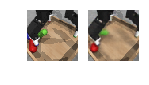

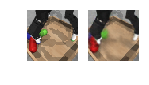

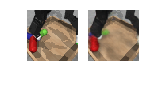

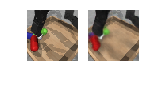

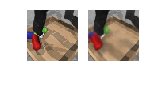

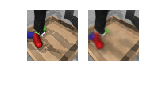

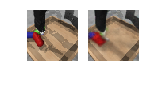

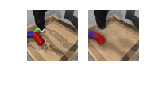

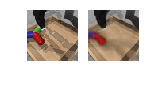

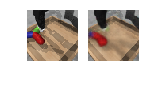

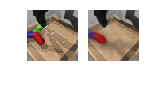

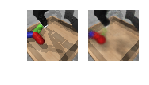

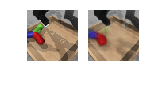

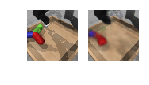

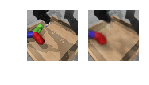

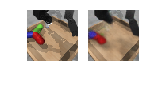

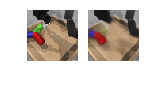

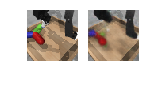

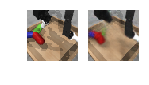

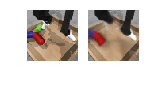

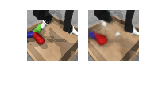

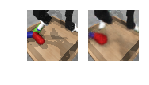

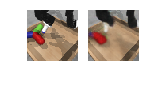

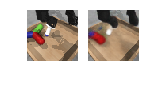

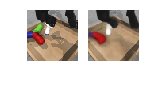

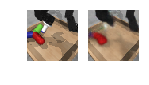

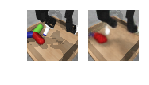

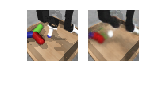

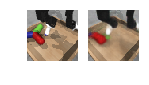

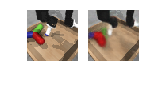

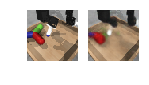

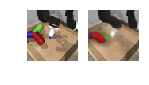

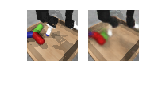

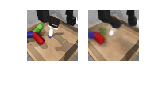

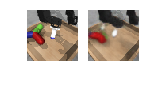

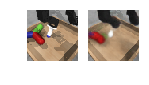

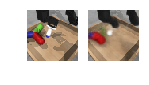

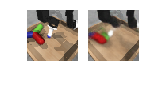

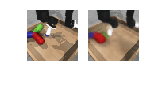

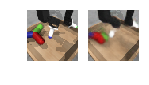

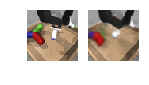

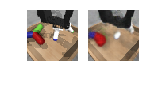

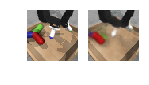

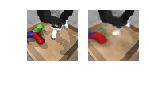

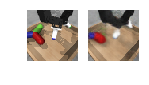

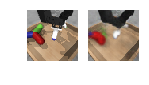

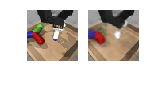

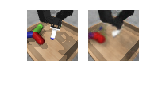

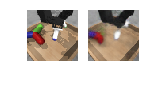

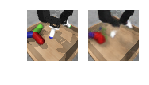

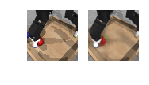

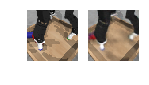

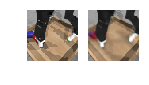

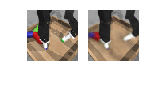

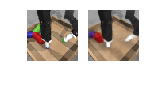

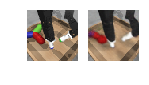

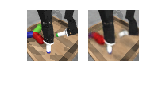

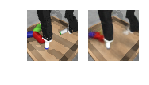

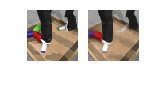

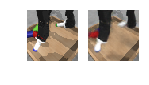

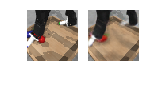

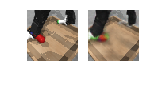

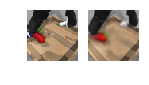

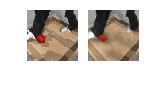

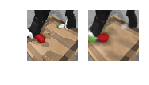

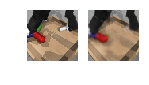

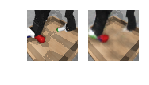

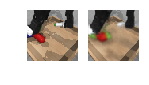

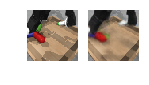

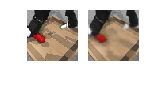

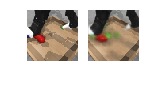

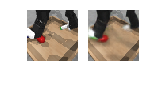

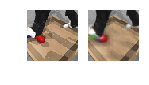

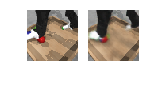

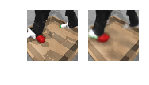

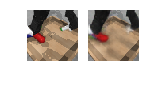

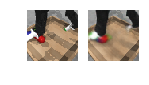

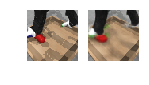

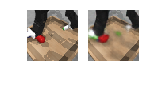

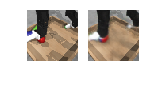

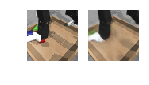

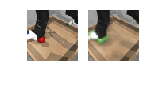

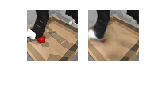

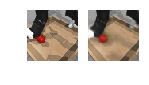

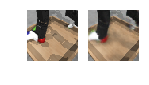

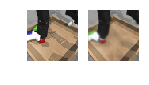

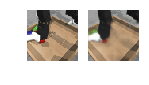

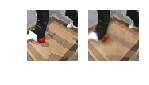

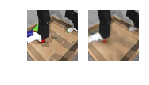

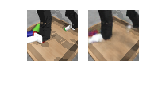

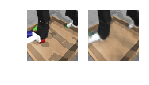

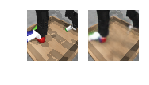

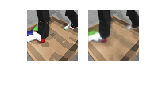

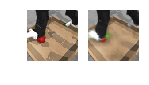

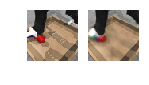

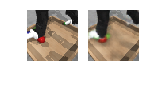

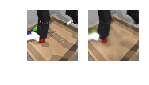

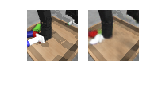

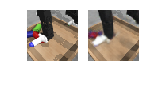

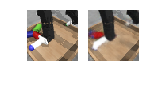

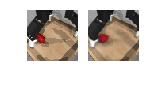

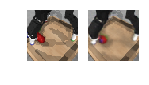

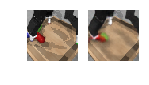

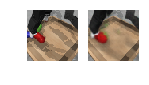

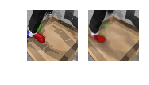

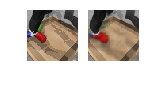

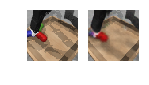

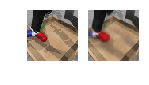

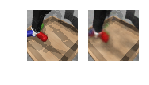

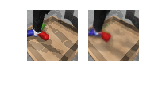

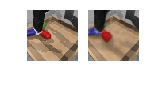

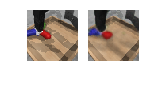

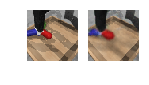

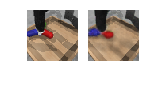

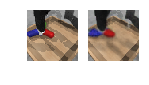

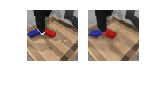

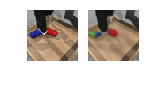

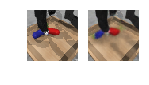

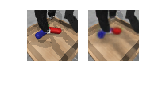

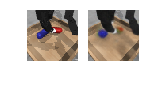

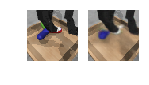

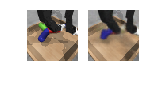

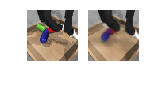

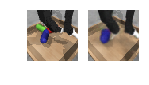

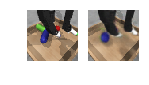

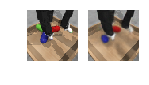

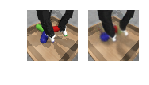

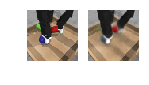

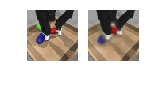

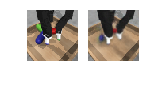

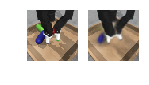

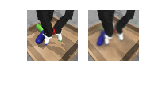

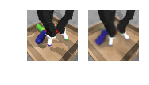

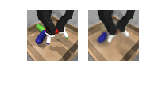

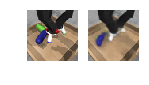

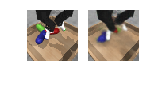

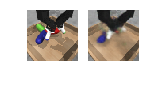

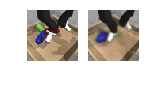

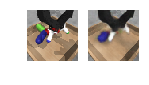

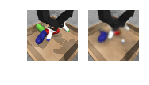

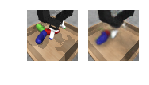

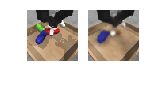

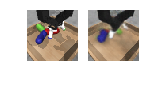

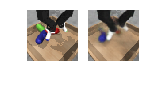

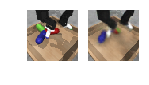

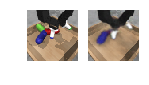

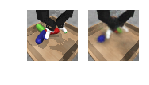

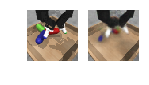

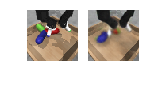

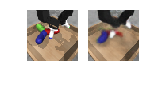

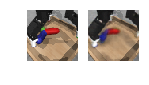

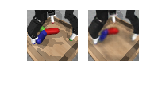

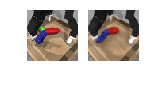

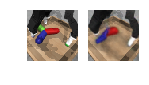

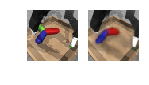

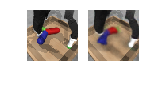

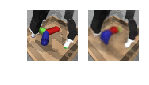

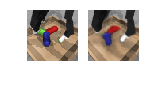

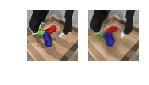

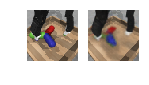

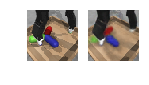

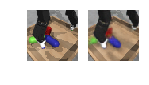

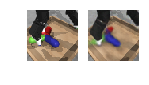

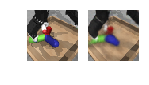

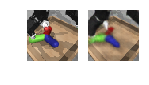

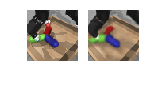

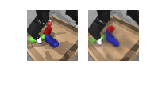

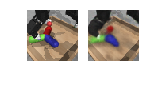

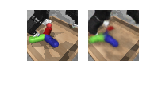

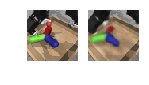

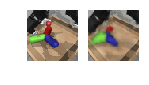

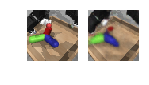

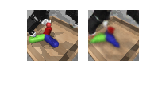

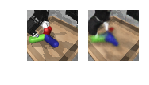

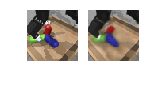

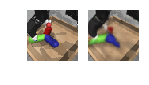

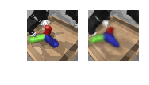

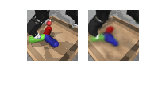

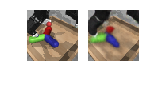

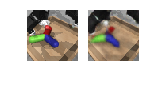

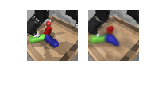

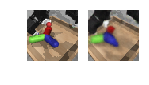

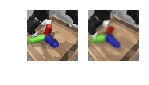

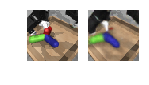

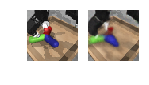

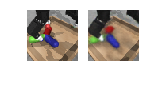

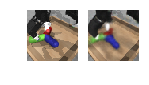

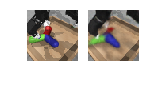

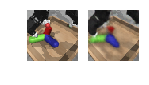

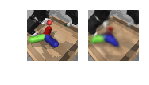

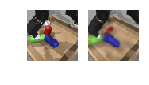

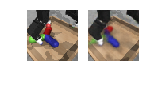

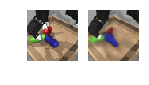

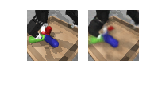

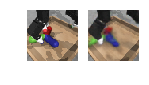

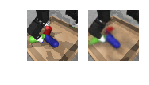

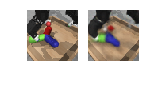

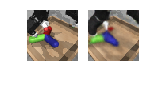

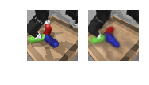

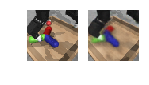

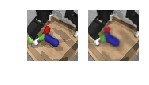

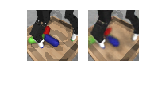

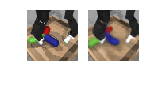

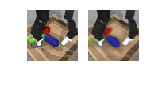

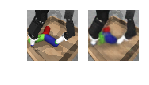

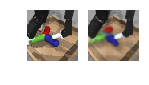

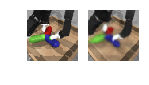

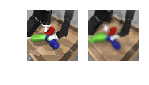

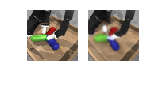

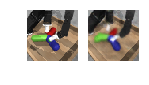

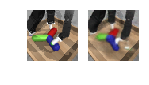

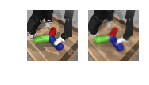

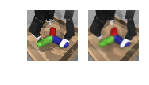

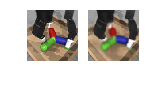

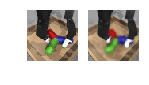

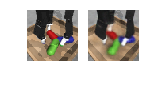

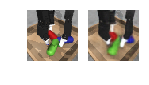

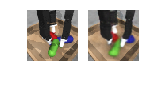

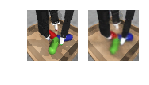

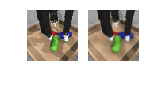

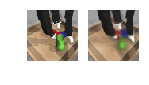

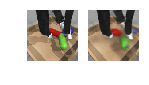

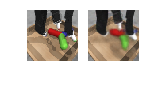

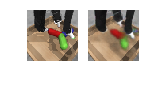

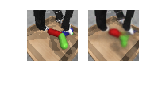

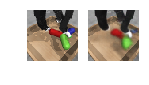

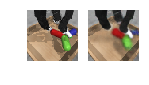

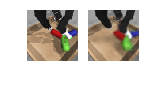

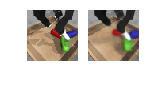

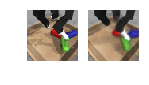

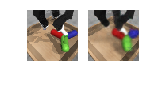

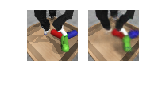

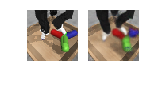

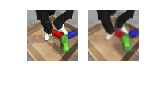

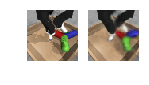

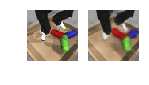

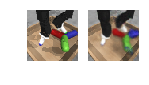

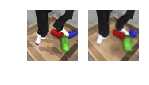

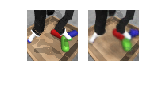

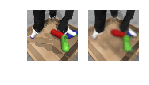

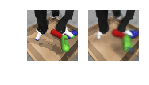

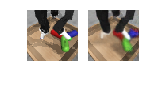

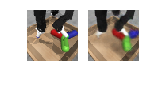

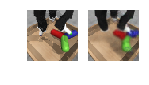

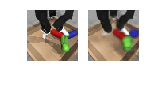

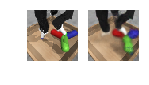

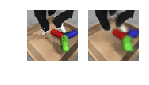

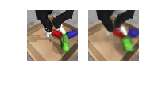

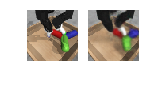

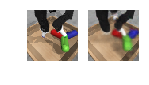

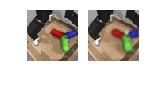

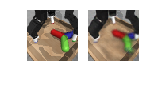

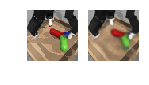

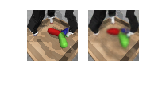

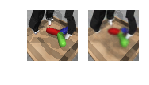

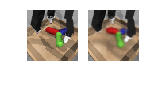

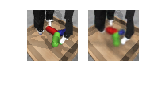

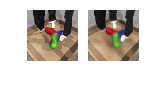

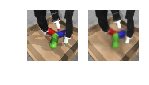

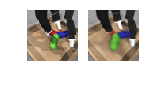

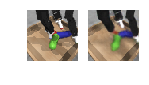

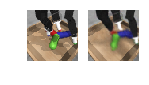

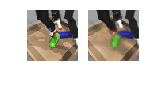

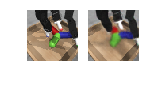

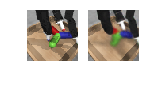

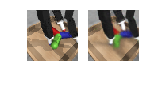

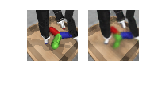

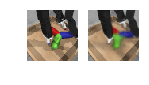

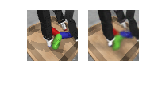

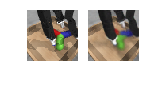

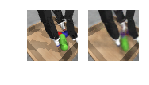

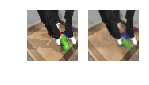

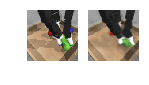

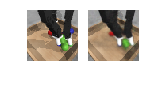

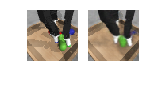

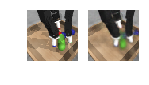

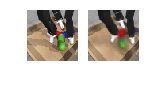

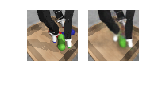

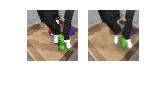

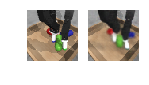

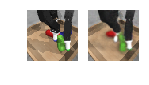

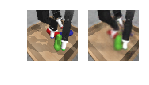

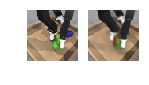

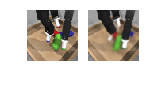

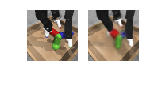

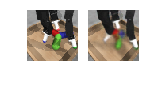

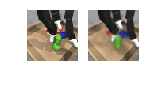

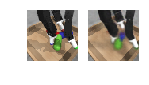

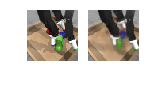

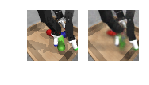

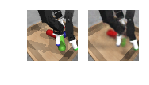

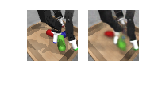

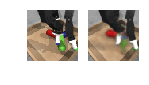

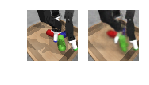

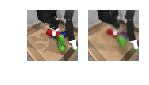

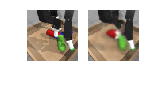

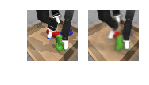

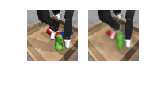

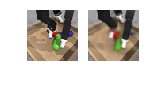

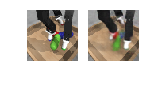

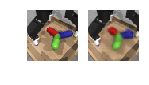

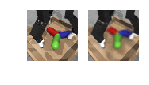

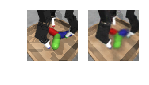

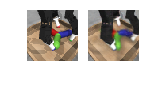

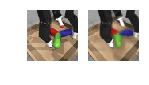

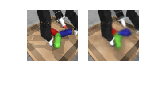

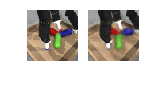

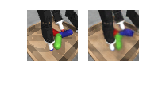

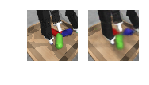

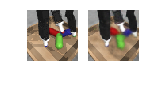

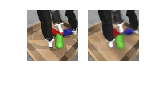

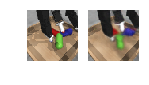

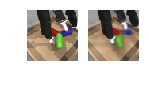

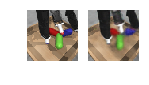

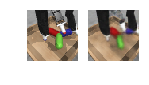

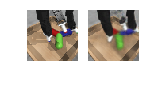

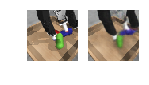

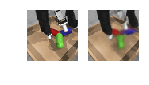

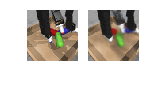

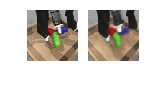

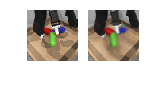

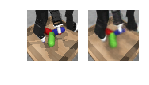

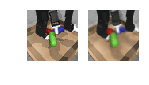

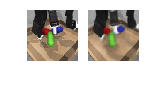

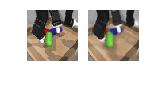

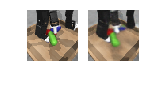

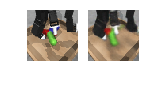

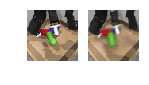

In [ ]:
for image in images[10500:11000]:
    image = (image / 255.).astype(np.float32)
    reconstruction = model(image[None, ...])
    plot_side_by_side(image, reconstruction[0], figsize=(2, 1))